In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from PIL import Image

#data from http://www.inalitic.com/datasets/mlb%20pitch%20data.html

Code Definitions #

While these aren't spelled out anywhere, play descriptions allowed confident identification of these codes

B - Ball

*B - Ball in dirt

S - Swinging Strike

C - Called Strike

F - Foul

T - Foul Tip

L - Foul Bunt

I - Intentional Ball

W - Swinging Strike (Blocked)

M - Missed Bunt

P - Pitchout

Q - Swinging pitchout

R - Foul pitchout

Values that only occur on last pitch of at-bat:

X - In play, out(s)

D - In play, no out

E - In play, runs

H - Hit by pitch

we need to look at 

px: left\right ball placement over plate, 0 is right down the middle

pz: up/down ball placement over plate, 0 is ground

sz_bot: bottom of strike zone from ground, in feet

sz_top: top of strike zone from ground, in feet

zone: PitchFX zone number. Labeled as 1-9 for inside strikezone and 11-14 for outside strikezone. there is no 10

type: Simplified pitch outcome codes, S (strike) B (ball) or X (in play)

s_count: Count of strikes for current at-bat and pitch sequence.

event: 	Description of at-bat result.

umpire_HP: 	Name of homeplate umpire for that game.

In [2]:
# ########### DO NOT RUN
# #load pitches.csv
# pitches = pd.read_csv('pitches.csv')

# #make pandas dataframe 
# pitch_df = pd.DataFrame(pitches)

In [3]:
# pitch_df.head(6)

In [4]:
# #list pitch_df columns
# # pitch_df.columns
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
# #get the first 100 rows of 'code'
# pitch_df['code'].head(100)

In [5]:
#remove unnecessary columns 'start_speed', 'end_speed', 'spin_rate', 'spin_dir','break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az','type_confidence', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0','z0', 'pfx_x', 'pfx_z', 'nasty','event_num', 'b_score', 'ab_id',outs','pitch_num', 'on_1b', 'on_2b', 'on_3b' 
# pitch_df = pitch_df.drop(['start_speed', 'end_speed', 'spin_rate', 'spin_dir','break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az','type_confidence', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0','z0', 'pfx_x', 'pfx_z', 'nasty','event_num', 'b_score', 'ab_id', 'outs','pitch_num', 'on_1b', 'on_2b', 'on_3b'], axis=1)


In [6]:
#get head of dataframe
# pitch_df.head()

In [7]:
#save as pickle
# pitch_df.to_pickle('pitch_df_sorted.pkl')

In [8]:
#load pickle
pitch_df = pd.read_pickle('pitch_df_sorted.pkl')

In [9]:
pitch_df.head()

,px,pz,sz_bot,sz_top,zone,code,type,pitch_type,b_count,s_count
0,0.416,2.963,1.72,3.56,3.0,C,S,FF,0.0,0.0
1,-0.191,2.347,1.72,3.56,5.0,S,S,FF,0.0,1.0
2,-0.518,3.284,1.72,3.56,1.0,F,S,FF,0.0,2.0
3,-0.641,1.221,1.74,3.35,13.0,B,B,FF,0.0,2.0
4,-1.821,2.083,1.72,3.56,13.0,B,B,CU,1.0,2.0


In [10]:
#list columns
pitch_df.columns

Index(['px', 'pz', 'sz_bot', 'sz_top', 'zone', 'code', 'type', 'pitch_type',
       'b_count', 's_count'],
      dtype='object')

In [11]:
strikes_df = pitch_df[pitch_df['code'] == 'C']
#get b code 
balls_df = pitch_df[pitch_df['code'] == 'B']
balls_df.head()

,px,pz,sz_bot,sz_top,zone,code,type,pitch_type,b_count,s_count
3,-0.641,1.221,1.74,3.35,13.0,B,B,FF,0.0,2.0
4,-1.821,2.083,1.72,3.56,13.0,B,B,CU,1.0,2.0
6,-1.088,1.610,1.59,3.45,13.0,B,B,FF,0.0,0.0
8,1.470,2.350,1.89,3.46,14.0,B,B,FF,0.0,0.0
9,-1.337,1.898,1.81,3.52,13.0,B,B,FF,1.0,0.0


In [12]:
#strike zone width is 17 inches
sz_width = 17/2/12
sz_width

0.7083333333333334

In [13]:
def get_false_strikes(strikes_df):

#make new df with same columns as pitch_df
    false_strikes_df = pd.DataFrame(columns=strikes_df.columns)
    true_strikes_df = pd.DataFrame(columns=strikes_df.columns)
#make list
    f_strikes_list = []
    t_strikes_list = []
    count = 0
    #iterate through each row of called strikes
    for index, row in strikes_df.iterrows():
        #get strike zone top and bottom
        sz_top = row['sz_top']
        sz_bot = row['sz_bot']

        #get half the strike zone height
        sz_height = (sz_top - sz_bot)

        sz_left = 0 - sz_width
        #get sz_right
        sz_right = 0 + sz_width
        #get x and y coordinates
        x = row['px']
        y = row['pz']
        #false strikes
        if x < sz_left or x > sz_right or y > sz_top or y < sz_bot:
            #shift strickzone vertical center to y = 0
            row['pz'] = row['pz'] - ((sz_height/2) + sz_bot)
            f_strikes_list.append(row)
        else:
            row['pz'] = row['pz'] - ((sz_height/2) + sz_bot)
            t_strikes_list.append(row)
        
        # print(strikes_list)
# count
    strikes_flase_df = pd.DataFrame(f_strikes_list)
    strikes_true_df = pd.DataFrame(t_strikes_list)
    return [strikes_flase_df, strikes_true_df]

In [14]:
def get_false_balls(balls_df_m):
    # print(balls_df_m.head())
#make new df with same columns as pitch_df
    false_balls_df = pd.DataFrame(columns=balls_df_m.columns)
    true_balls_df = pd.DataFrame(columns=balls_df_m.columns)
#make list
    false_balls_list = []
    true_balls_list = []
    count = 0
    #iterate through each row of called strikes
    for index, row in balls_df_m.iterrows():
        #get strike zone top and bottom
        sz_top = row['sz_top']
        sz_bot = row['sz_bot']

        sz_height = (sz_top - sz_bot)

        sz_left = 0 - sz_width
        #get sz_right
        sz_right = 0 + sz_width
        #get x and y coordinates
        x = row['px']
        y = row['pz']

        if x < sz_left or x > sz_right or y > sz_top or y < sz_bot:
            row['pz'] = row['pz'] - ((sz_height/2) + sz_bot)
            true_balls_list.append(row)
        else:
            row['pz'] = row['pz'] - ((sz_height/2) + sz_bot)
            false_balls_list.append(row)
        # print(strikes_list)
# count

    false_balls_df = pd.DataFrame(false_balls_list)
    true_balls_df = pd.DataFrame(true_balls_list)
    return false_balls_df, true_balls_df

In [15]:
false_strikes_df, true_strikes_df = get_false_strikes(strikes_df)


In [16]:
# true_strikes_df.head(100)

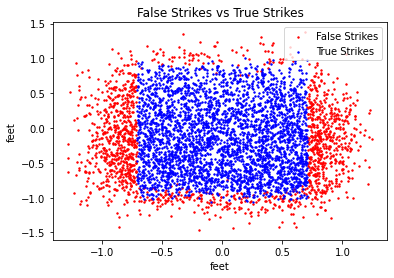

<Figure size 720x720 with 0 Axes>

In [27]:
#plot false strikes in red and true strikes in blue only use 10% of the rows
false_strikes_df_sample = false_strikes_df.sample(frac=0.01)
true_strikes_df_sample = true_strikes_df.sample(frac=0.01)
plt.scatter(false_strikes_df_sample['px'], false_strikes_df_sample['pz'], color='red', label='False Strikes', s= 2)
plt.scatter(true_strikes_df_sample['px'], true_strikes_df_sample['pz'], color='blue', label='True Strikes', s= 2)
plt.xlabel('feet')
plt.ylabel('feet')
plt.title('False Strikes vs True Strikes')
plt.legend()
plt.show()
# save as png using pil

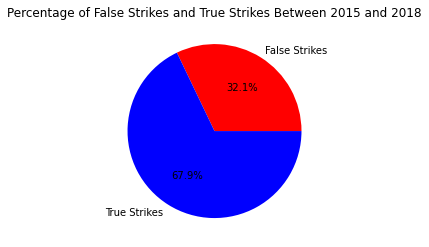

<Figure size 432x288 with 0 Axes>

In [18]:
#make pie chart of false strikes red and true strikes blue
plt.pie([len(false_strikes_df), len(true_strikes_df)], labels=['False Strikes', 'True Strikes'], colors=['red', 'blue'], autopct='%1.1f%%')
plt.title('Percentage of False Strikes and True Strikes Between 2015 and 2018')
plt.show()
plt.savefig('false_strikes_pie_chart.png')

In [19]:
false_balls_df, true_balls_df = get_false_balls(balls_df)

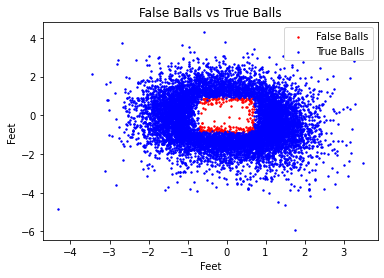

<Figure size 432x288 with 0 Axes>

In [20]:
false_balls_df_sample = false_balls_df.sample(frac=0.01)
true_balls_df_sample = true_balls_df.sample(frac=0.01)
plt.scatter(false_balls_df_sample['px'], false_balls_df_sample['pz'], color='red', label='False Balls', s= 2)
plt.scatter(true_balls_df_sample['px'], true_balls_df_sample['pz'], color='blue', label='True Balls', s= 2)
plt.xlabel('Feet')
plt.ylabel('Feet')
plt.title('False Balls vs True Balls')
plt.legend()
plt.show()
plt.savefig('false_balls_1%_of_pitches.png')

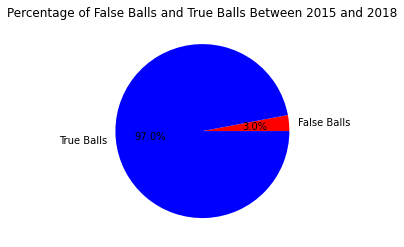

<Figure size 432x288 with 0 Axes>

In [21]:
plt.pie([len(false_balls_df), len(true_balls_df)], labels=['False Balls', 'True Balls'], colors=['red', 'blue'], autopct='%1.1f%%')
plt.title('Percentage of False Balls and True Balls Between 2015 and 2018')
plt.show()
plt.savefig('false_balls_pie_chart.png')